# Tabu Search (Travelling Salesman)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import dist

## Single state, contains tour and cost

In [2]:
class State:
    def __init__(self) -> None:
        self.tour = []
        self.cost = 0
        self.change = (0,0)

    def __repr__(self) -> str:
        return f'Node(position={self.tour}, cost={self.cost})'

    def __lt__(self, other):
        return self.cost < other.cost

### X and Y coordinates for different graphs

In [3]:
x1 = [0.09 , 0.16 , 0.84 , 0.70]
y1 = [0.17,   0.52,  0.92, 0.16]

x2 = [16.47000,16.47000,20.09000,22.39000,25.23000,22,20.47000,17.20000,16.30000,14.05000,16.53000,21.52000,19.41000,20.09000]
y2 = [96.10000,94.44000,92.54000,93.37000,97.24000,96.05000,97.02000,96.29000,97.38000,98.12000,97.38000,95.59000,97.13000,94.55000]

x3 = [7,9,2,0,0,1,7,1,2,51,42,31,5,12,36,52,27,17,13,57,62,42,16,8,7,27,30,43,58,58,37,38,46,61,62,63,32,45,59,5,10,21,5,30,39,32,25,25,48,56]
y3 = [52,49,64,26,30,47,63,62,33,21,41,32,25,42,16,41,23,33,13,58,42,57,57,52,38,68,48,67,48,27,69,46,10,33,63,69,22,35,15,6,17,10,64,15,10,39,32,55,28,37]

x4 = [1380,2848,3510,457,3888,984,2721,1286,2716,738,1251,2728,3815,3683,1247,123,1234,252,611,2576,928,53,1807,274,2574,178,2678,1795,3384,3520,1256,1424,3913,3085,2573,463,3875,298,3479,2542,3955,1323,3447,2936,1621,3373,1393,3874,938,3022,2482,3854,376,2519,2945,953,2628,2097,890,2139,2421,2290,1115,2588,327,241,1917,2991,2573,19,3911,872,2863,929,839,3893,2178,3822,378,1178,2599,3416,2961,611,3113,2597,2586,161,1429,742,1625,1187,1787,22,3640,3756,776,1724,198,3950]
y4 = [939,96,1671,334,666,965,1482,525,1432,1325,1832,1698,169,1533,1945,862,1946,1240,673,1676,1700,857,1711,1420,946,24,1825,962,1498,1079,61,1728,192,1528,1969,1670,598,1513,821,236,1743,280,1830,337,1830,1646,1368,1318,955,474,1183,923,825,135,1622,268,1479,981,1846,1806,1007,1810,1052,302,265,341,687,792,599,674,1673,1559,558,1766,620,102,1619,899,1048,100,901,143,1605,1384,885,1830,1286,906,134,1025,1651,706,1009,987,43,882,392,1642,1810,1558]

        

## Creating a graph

In [4]:
class Graph:
    def __init__(self, x, y) -> None:
        self.n = n = len(x)
        self.x = np.array(x, dtype=float)
        self.y = np.array(y, dtype=float)
        self.edges = np.zeros(shape=(n,n), dtype=float)

        for i in range(self.n):
            for j in range(self.n):
                self.edges[i,j] = dist([x[i], y[i]], [x[j], y[j]])

## Make a set of plots for visualization before and after optimization

In [5]:
def make_plots(costs, tour, before, graph):
  fig, ax =  plt.subplots(1, 3, figsize=(15, 5))

  # first plot, for tour before optimization
  plot_x = []
  plot_y = []
  for i in before:
      plot_x.append(graph.x[i])
      plot_y.append(graph.y[i])
  plot_x.append(graph.x[before[0]])
  plot_y.append(graph.y[before[0]])
  
  ax[0].set_ylabel('Y')
  ax[0].set_xlabel('X')
  ax[0].plot(plot_x, plot_y, marker='o', color='red', linestyle='dashed')

  # second plot, for cost vs iteration
  ax[1].set_ylabel('Value of A.cost')
  ax[1].set_xlabel('Iteration #')
  ax[1].plot(costs)

  # third plot, for tour after optimization
  plot_x = []
  plot_y = []
  for i in tour:
      plot_x.append(graph.x[i])
      plot_y.append(graph.y[i])
  plot_x.append(graph.x[tour[0]])
  plot_y.append(graph.y[tour[0]])

  ax[2].set_ylabel('Y')
  ax[2].set_xlabel('X')
  ax[2].plot(plot_x, plot_y, marker='o', color='green', linestyle='dashed')

## Defining the objective funtion

In [6]:
def objective(tour, graph):
    fitn = 0
    n = len(tour)
    for i in range(n-1):
        fitn += graph.edges[tour[i], tour[i+1]]

    fitn += graph.edges[tour[0], tour[-1]]
    return fitn

## Defining the neighbour funtion

In [7]:
def find_neighbours(A):
    neighbours = []
    n = len(A.tour)
    for i in range(n):
        for j in range(i+1,n):
            B = State()
            B.tour = A.tour.copy()
            B.tour[i], B.tour[j] = B.tour[j], B.tour[i]
            B.cost = objective(B.tour, graph)
            B.change = (B.tour[i], B.tour[j])
            neighbours.append(B)

    neighbours.sort()  # change for maximization
    return neighbours

## Tabu Search funtion

In [8]:
def find_optimum(A, max_iter, k):

    costs = []
    best_cost = A.cost
    best_tour = A.tour
    n = len(A.tour)
    tabu = np.zeros(shape=(n,n), dtype=float) # tabu list

    for i in range(max_iter):
        neighbours = find_neighbours(A)
        # print('\n\n', A.tour, A.cost) # debug
        # print('i =', i, '\n', tabu) # debug

        for B in neighbours:

            (a,b) = B.change
            if a > b:
                a, b = b, a

            if tabu[a,b] <= i:
                A.tour = B.tour.copy()
                A.cost = B.cost
                # print('Changed') # debug
                tabu[a,b] = i+k # forbidding strategy
                break
            elif B.cost < best_cost: # freeing strategy
                A.tour = B.tour.copy()
                A.cost = B.cost
                # print('Changed') # debug
                tabu[a,b] = i+5
                break

        costs.append(A.cost)
        if A.cost < best_cost:
            best_cost = A.cost
            best_tour = A.tour.copy()

    return best_tour, best_cost, costs

## Graph 1

Starting cost :  3.108664680002766
Final cost :  2.5287238080453878


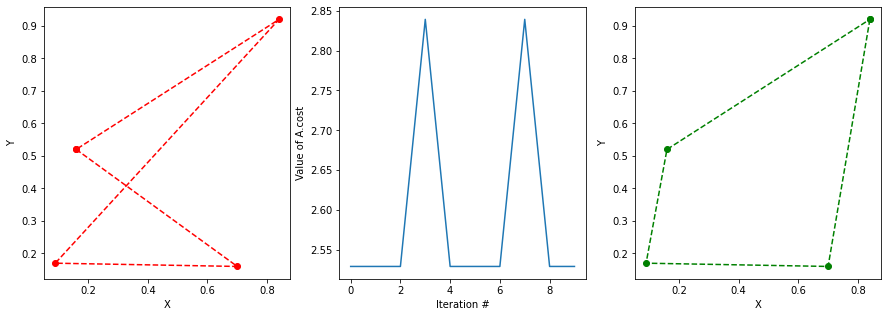

In [9]:
A = State()
graph = Graph(x1, y1)
n = graph.n
A.tour = list(range(n))
random.shuffle(A.tour)
A.cost = objective(A.tour, graph)
max_iter = 10
T = 1
alpha = 0.99

# print('Starting tour : ', A.tour)
print('Starting cost : ', A.cost)

before = A.tour.copy()
sol_tour, sol_cost, costs = find_optimum(A, max_iter, 3)
make_plots(costs, sol_tour, before, graph)

# print('Optimum tour : ', sol.tour)
print('Final cost : ', sol_cost)

## Graph 2

Starting cost :  51.879024334803226
Final cost :  30.878503892588


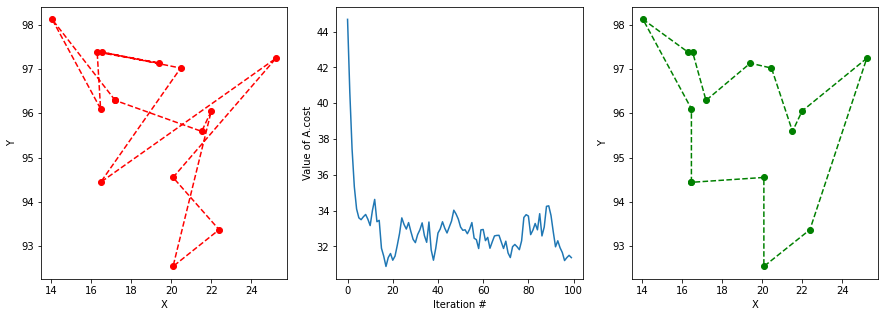

In [10]:
A = State()
graph = Graph(x2, y2)
n = graph.n
A.tour = list(range(n))
random.shuffle(A.tour)
A.cost = objective(A.tour, graph)
max_iter = 100
T = 1
alpha = 0.999

# print('Starting tour : ', A.tour)
print('Starting cost : ', A.cost)

before = A.tour.copy()
sol_tour, sol_cost, costs = find_optimum(A, max_iter, 10)
make_plots(costs, sol_tour, before, graph)

# print('Optimum tour : ', sol.tour)
print('Final cost : ', sol_cost)

## Graph 3

Starting cost :  1881.8158315962357
Final cost :  545.5403390465399


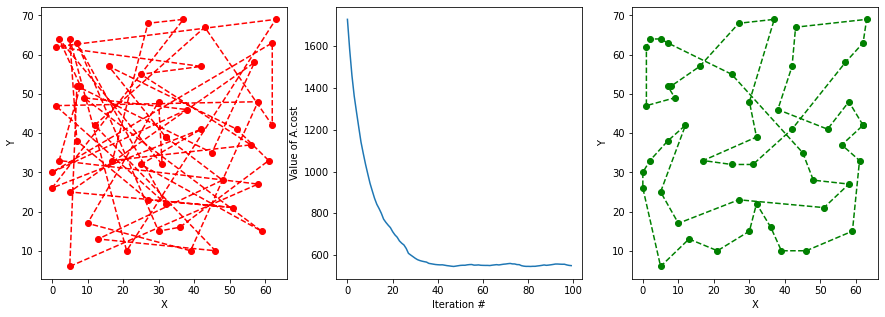

In [11]:
A = State()
graph = Graph(x3, y3)
n = graph.n
A.tour = list(range(n))
random.shuffle(A.tour)
A.cost = objective(A.tour, graph)
max_iter = 100

# print('Starting tour : ', A.tour)
print('Starting cost : ', A.cost)

before = A.tour.copy()
sol_tour, sol_cost, costs = find_optimum(A, max_iter, 10)
make_plots(costs, sol_tour, before, graph)

# print('Optimum tour : ', sol.tour)
print('Final cost : ', sol_cost)

## Graph 4

Starting cost :  174108.24996519857
Final cost :  36958.019780844515


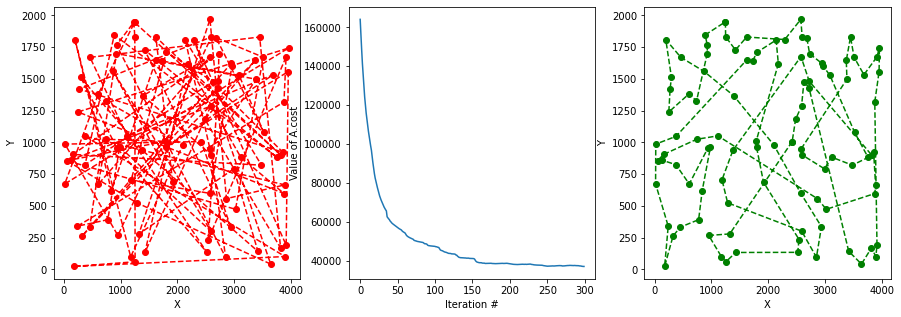

In [12]:
A = State()
graph = Graph(x4, y4)
n = graph.n
A.tour = list(range(n))
random.shuffle(A.tour)
A.cost = objective(A.tour, graph)
max_iter = 300

# print('Starting tour : ', A.tour)
print('Starting cost : ', A.cost)

before = A.tour.copy()
sol_tour, sol_cost, costs = find_optimum(A, max_iter, 30)
make_plots(costs, sol_tour, before, graph)

# print('Optimum tour : ', sol.tour)
print('Final cost : ', sol_cost)